In [5]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy

#compare
p0 = 101325
T0 = 300 #paper
phi = 0.7
alpha = 0.6 #paper>0.6~0.8
width = 0.02 #2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [6]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0]
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [7]:
# get adiabatic temperature from the FreeFlame object
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame)   ## (Viken) adiabatic temperature should be from the laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1] ## (viken)
print(Xflame)

### (viken) use laminar flame to compute the thermal diffusivity, only needed once per operating conditions
cp      = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_     = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

Adiabatic temperature (Tad) from FreeFlame: 1820.61 K
[8.71644776e-05 7.95833396e-06 7.46969856e-05 6.34393393e-02
 1.04592808e-03 1.63357505e-01 8.79471851e-07 5.71270861e-08
 9.92200951e-23 1.88668730e-20 5.67881302e-18 3.91281319e-19
 2.93527169e-16 8.62101305e-16 1.25910290e-04 4.78041079e-02
 4.75925324e-13 4.02540126e-15 4.01345221e-19 1.25728563e-19
 1.36775492e-17 2.58929271e-21 3.77511100e-18 1.85806459e-21
 2.02368726e-19 5.01516973e-25 2.70013201e-24 4.45486262e-19
 1.43802702e-17 1.43799870e-17 2.53286906e-11 5.53589272e-12
 1.05437771e-12 4.26040245e-12 1.21412864e-11 5.27625597e-06
 7.32844418e-09 2.86514313e-07 2.28403938e-11 2.79031459e-16
 8.36793567e-13 1.91036880e-20 2.59278444e-23 1.08691966e-13
 2.67471003e-13 4.84142594e-12 1.15195009e-13 7.24050883e-01
 1.08107410e-46 5.11117094e-29 2.46071090e-27 1.38251860e-22
 7.86432283e-20]


In [8]:
def calculate_heat_loss_coefficient(Tp, Tad, Tr):
    beta = (Tp - Tr) / (Tad - Tr)
    return beta

#Tp = flame_cf.products.T  ## (Viken)
#Tr = T0

In [9]:
#check minus sign (integral_numerator, mass_fraction_diff)
#modify the func to reflect Ka, beta?
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    #print("Integral Numerator:", integral_numerator) #check if it has a right sign
    #print("Mass Fraction Difference:", mass_fraction_diff)
    return S_cF

#ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
#print(ScF)

In [15]:
# Set mass flow range, calculate ScF (example values)
mdot_values = [1,2,3,4,5,6,7,8,9,10] ## (viken)
ScF_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tad  ## (viken) no heat loss
    flame_cf.products.X = Xflame     ## (viken)
    flame_cf.set_initial_guess(equilibrate=False)
    #print(gas) #Check if a different gas is being used #(viken)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    #Tp = flame_cf.products.T  ## (viken) you are reading the product temperature, you should write it
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])  # Ensure positive value for Ka calculation
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value # (viken) corrected Ka formula 
    print(f"Strain rate (Ka): {Ka:.5e}") # (viken) Ka is without dimention
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)
    
print(ScF_values)

Strain rate (Ka): 1.03364e+00
Strain rate (Ka): 1.02455e+00
Strain rate (Ka): 9.94012e-01
Strain rate (Ka): 9.53007e-01
Strain rate (Ka): 9.13680e-01
Strain rate (Ka): 1.09662e+00
Strain rate (Ka): 1.27963e+00
Strain rate (Ka): 1.46387e+00
Strain rate (Ka): 1.64831e+00
Strain rate (Ka): 1.83734e+00
[0.277824224877616, 0.28626527017090303, 0.29023076814023724, 0.29182690652472787, 0.29204774063928796, 0.2905969181111029, 0.2889735530121754, 0.28788105424485616, 0.28576528445532895, 0.2839492073664712]


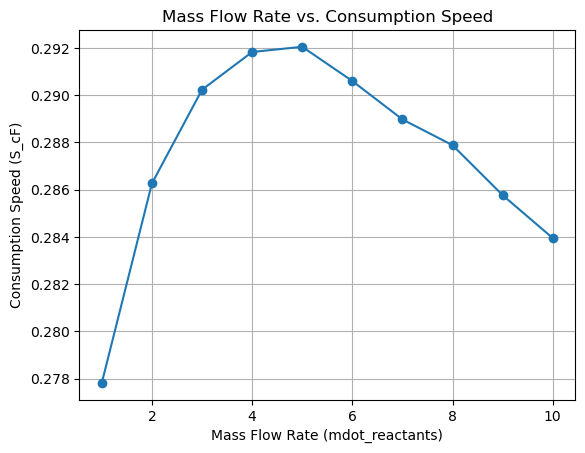

In [16]:
plt.plot(mdot_values, ScF_values, marker='o')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('Consumption Speed (S_cF)')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()

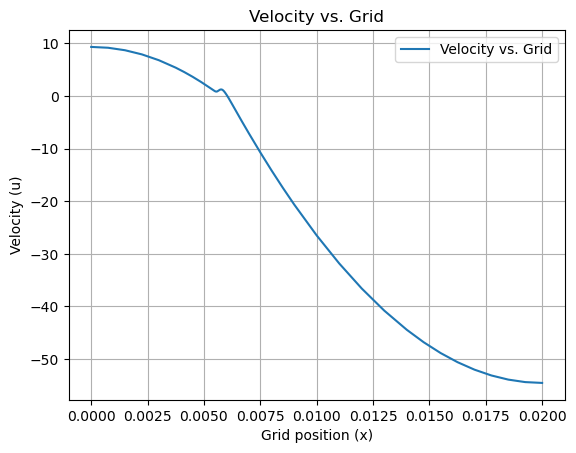

In [17]:
# plot grid-velocity graph
plt.plot(flame_cf.grid, flame_cf.velocity, label='Velocity vs. Grid')
plt.xlabel('Grid position (x)')
plt.ylabel('Velocity (u)')
plt.title('Velocity vs. Grid')
plt.legend()
plt.grid(True)
plt.show()